In [1]:
from constants import *

In [2]:
n_channels = 22

data_path = '/Users/seonghyunyoon/Developer/cp-eeg/Data/2aiv/'
save_path = '/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 1 (ideal)/'
model_path = f'{save_path}/saved_models/'

In [3]:
all_X_train = [] 
all_y_train = [] 
all_X_val = []
all_y_val = []
all_X_test = []
all_y_test = []

all_models = [] 

for subject_num in tqdm(range(1, 10)): 
    # Load data 
    X_train, y_train = get_data(subject_num, training=True, path=data_path)
    X_val_test, y_val_test = get_data(subject_num, training=False, path=data_path)
    X_train, y_train = prepare_features(X_train, y_train)
    X_val_test, y_val_test = prepare_features(X_val_test, y_val_test)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=.65, random_state=42)
    
    # Scale the data
    for j in range(n_channels):
        scaler = StandardScaler()
        scaler.fit(X_train[:,0,j,:])
        X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
        X_val[:,0,j,:] = scaler.transform(X_val[:,0,j,:])
        X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])
    
    # Append to total data 
    all_X_train.append(X_train)
    all_y_train.append(y_train)
    all_X_val.append(X_val)
    all_y_val.append(y_val)
    all_X_test.append(X_test)
    all_y_test.append(y_test)
    
    # Prepare model
    curr_model_path = f'{model_path}/model_{subject_num}.h5'
    _, _, n_channels, n_time = X_train.shape
    n_classes = y_train.shape[1]
    model = EEGTCNet(nb_classes = n_classes, Chans=n_channels, Samples=n_time, layers=L, kernel_s=KT, filt=FT, dropout=pt, activation='elu', 
                     F1=F1, D=2, kernLength=KE, dropout_eeg=pe)
    model.load_weights(curr_model_path)
    all_models.append(model)

  0%|          | 0/9 [00:00<?, ?it/s]

In [4]:
total = 0 
for i in range(9): 
    total += all_X_test[i].shape[0]

In [11]:
0.62 * total / 9

57.38444444444445

## Calibration plot

In [256]:
# Prepare all values of alphas 
all_alphas = np.arange(0.01, 0.99, 0.01)
n_alphas = len(all_alphas)
n_iters = 100
n_classes = 4

empirical_coverages = np.zeros((9 * n_iters, n_alphas))
accuracies = np.zeros((9 * n_iters, n_alphas))
prediction_rates = np.zeros((9 * n_iters, n_alphas))

baseline_accuracy = np.zeros((9,))

for subject_num in tqdm(range(9)): 
    # Load Relevant model and data
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    
    for i_alpha, alpha in enumerate(all_alphas): 
        for i_iter in range(n_iters): 
            save_idx = subject_num*n_iters + i_iter
            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=False)
            empirical_coverages[save_idx, i_alpha] = get_coverage(y_test, pred_set)

            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True)
            set_size = get_set_size(pred_set, n_classes)
            prediction_rates[save_idx, i_alpha] = (set_size[0] + set_size[1]) / sum(set_size.values())
            accuracies[save_idx, i_alpha] = get_abstain_metrics(pred_set, test_smx, y_test, verbose=False)
        
    baseline_accuracy[subject_num] = np.mean(test_smx.argmax(1) == y_test.argmax(1))
    
np.save(f'{save_path}baseline_accuracies.npy', baseline_accuracy)
np.save(f'{save_path}empirical_coverages.npy', empirical_coverages)
np.save(f'{save_path}accuracies.npy', accuracies)
np.save(f'{save_path}prediction_rates.npy', prediction_rates)

  0%|          | 0/9 [00:00<?, ?it/s]

3/3 [==============================] - 0s 17ms/step


In [13]:
baseline_accuracy = np.load(f'{save_path}baseline_accuracies.npy')
empirical_coverages = np.load(f'{save_path}empirical_coverages.npy')
accuracies = np.load(f'{save_path}accuracies.npy')
prediction_rates = np.load(f'{save_path}prediction_rates.npy')

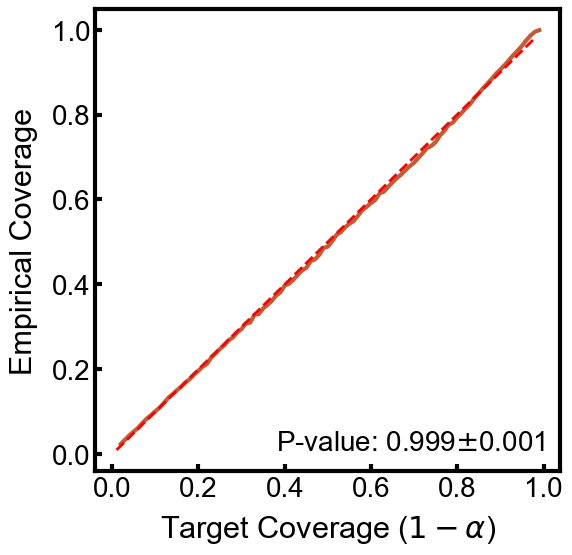

In [14]:
plot_average_coverage(empirical_coverages)

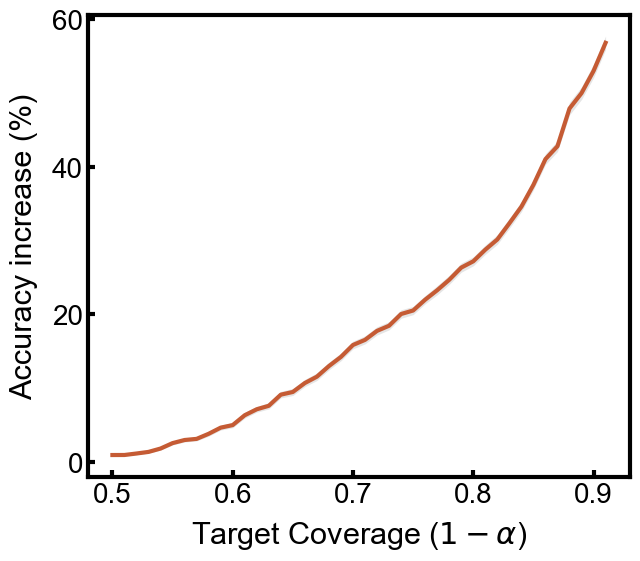

In [15]:
acc_improvement, acc_avg, acc_ci_lower, acc_ci_upper = plot_average(np.expand_dims(accuracies, axis=0), plot_type='accuracies', 
                                                                    baseline_accuracy=baseline_accuracy, n_iters=100)

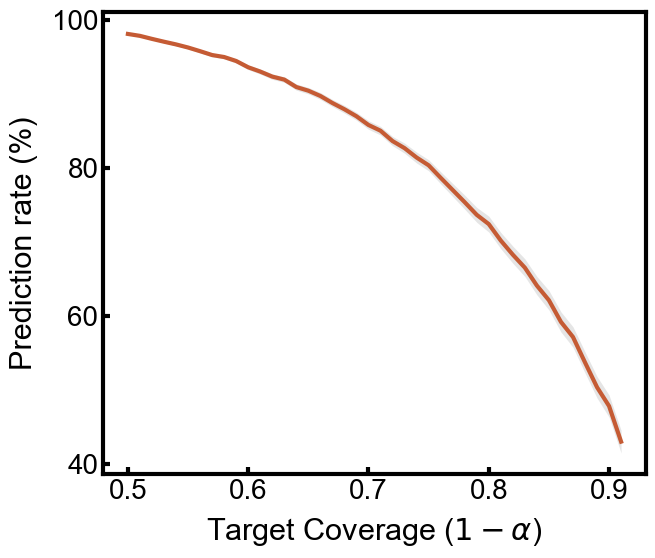

In [16]:
pr_avg, pr_ci_lower, pr_ci_upper = plot_average(np.expand_dims(prediction_rates, axis=0), plot_type='prediction_rates')

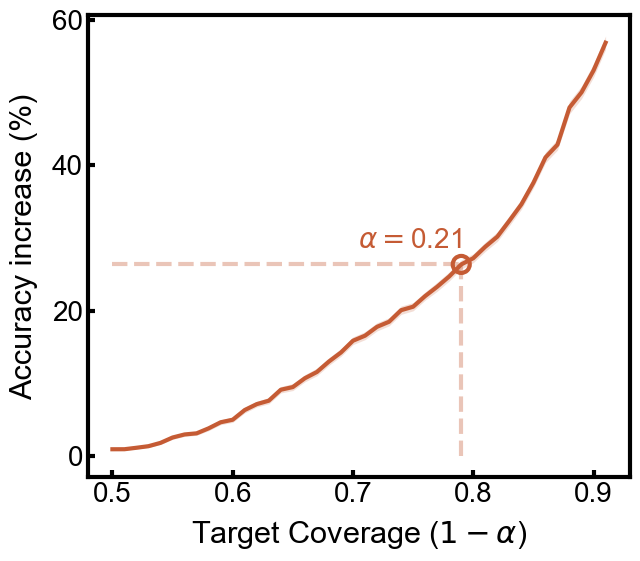

In [17]:
alpha_max = normalized_f1_score(acc_improvement.T, pr_avg)
plot_average_with_optimum(acc_avg, acc_ci_lower, acc_ci_upper, plot_type='accuracies', max_alpha_idx=alpha_max, x_adj=-0.0, y_adj=5)

In [21]:
acc_avg[0,alpha_max]

26.34241298076795

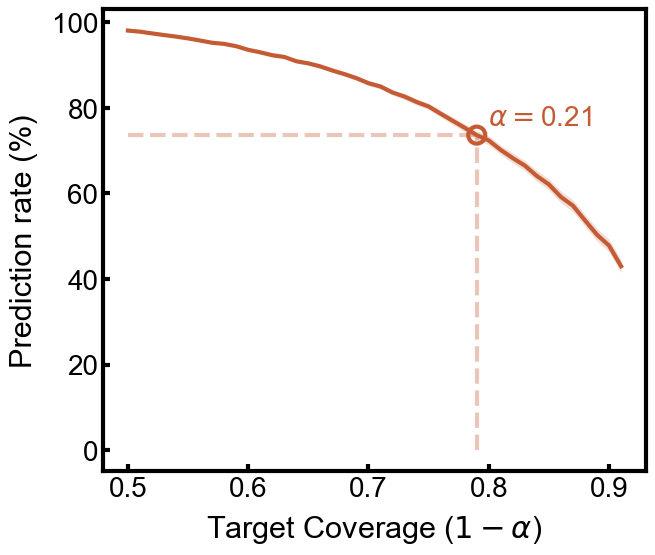

In [261]:
plot_average_with_optimum(pr_avg, pr_ci_lower, pr_ci_upper, plot_type='prediction_rates', max_alpha_idx=alpha_max, x_adj=0.095, y_adj=7)

In [24]:
100- pr_avg[0,alpha_max]

26.354409435762435

## Covariate shift testing

In [15]:
from scipy.stats import kstest

n_iters = 100

np.random.seed(42) 

pvalues = np.zeros((9, 100, n_iters))
sample_percentages = list(np.arange(0.01, 1.01, 0.01)) 

for subject_num in tqdm(range(9)): 
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    n_test = X_test.shape[0]
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    
    for percentage_idx, test_percentage in enumerate(sample_percentages):
        curr_n_test = int(np.ceil(n_test * test_percentage))  # Ceil to avoid empty set 
        for i in range(n_iters): 
            random_indices = np.random.choice(n_test, size=curr_n_test, replace=False)
            val_score, test_score = get_conformity_scores(val_smx, y_val, test_smx[random_indices], y_test[random_indices])
            pvalues[subject_num, percentage_idx, i] = kstest(val_score, test_score)[1]

np.save(f'{save_path}/pvalues.npy', pvalues)

  0%|          | 0/9 [00:00<?, ?it/s]

In [14]:
pvalues = np.load(f'{save_path}/pvalues.npy')

In [15]:
pvalues_reshaped = pvalues.transpose(0, 2, 1)
pvalues_reshaped = pvalues_reshaped.reshape((pvalues.shape[0] * pvalues.shape[2], pvalues.shape[1]))

In [17]:
def plot_average_pval(pvalues, x_low=0.01, x_high=1.01, x_int=0.01): 
    x = np.arange(x_low, x_high, x_int)
    fig = plt.figure(figsize=(12, 6))
    plt.rcParams['font.family'] = 'Arial'

    avg, ci_lower, ci_upper = compute_ci_mean(pvalues)
    plt.plot(100 * x, [0.05] * len(x), 'r--', linewidth=3)
    plt.plot(100 * x, avg, color=color_scheme[0], linewidth=3)
    plt.fill_between(100 * x, ci_lower, ci_upper, color=color_scheme[0], alpha=.2, linewidth=0)
    plt.grid(False)

    plt.tick_params(axis='both',          # Applies to both x and y axis
                    which='both',         # Applies to both major and minor ticks
                    direction='in',       # Sets ticks to the inside
                    bottom=True,          # Enables bottom ticks
                    top=False,             # Enables top ticks
                    left=True,            # Enables left ticks
                    right=False)           # Enables right ticks
    plt.tick_params(axis='both', length=5, width=3)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(3)  # Set the thickness here

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20) 

    #plt.xticks(x, labels=['0', '20', '40', '60', '80', '100'], fontsize=20) 

    plt.xlabel('Percent of data (%)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
    plt.ylabel('P-value', fontsize=22, labelpad=10, fontdict=dict(fontstretch = 'condensed'))#, fontdict=dict(weight='bold'))
    plt.ylim(0, 1.05)

    plt.text(65.5, 0.95, rf'Does not reach p < 0.05', fontsize=19.5, fontdict=dict(fontstretch = 'condensed'))
    plt.plot([57.5, 63.5], [0.971, 0.971], color=color_scheme[0], linewidth=3)
    first_percentage = np.argmax(avg <= 0.05)
    if first_percentage == 0: 
        print('Does not reach p < 0.05')
    else: 
        print(f'Reaches p < 0.05 at {x[first_percentage]}')
    plt.show()

Does not reach p < 0.05


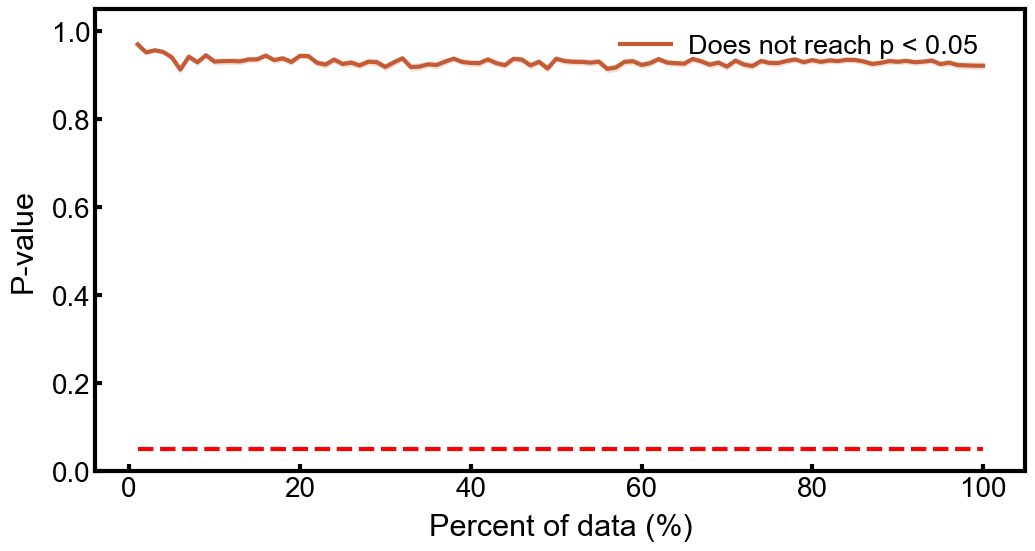

In [18]:
plot_average_pval(pvalues_reshaped)  # Bit of indexing magic

## Safety analysis

In [265]:
# True labels are treated as when the classifier gives us correct labels VS incorrect labels. 
# I.e., the CP abstaining framework is treated like a binary classifier on when to abstain or not. 

np.random.seed(42)

all_alphas = list(np.arange(0.01, 1.00, 0.01))

n_iters = 100
true_positives = np.zeros((9, len(all_alphas), n_iters)); true_negatives = np.zeros((9, len(all_alphas), n_iters))
false_positives = np.zeros((9, len(all_alphas), n_iters)); false_negatives = np.zeros((9, len(all_alphas), n_iters))
baseline_accuracies = np.zeros((9,))

for subject_num in tqdm(range(9)): 
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    true_abstain = test_smx.argmax(1) != y_test.argmax(1); true_noabstain = ~true_abstain
    baseline_accuracies = np.mean(true_noabstain)
    for i_alpha, alpha in enumerate(all_alphas): 
        for j in range(n_iters): 
            ps, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=1-alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True, verbose=False)
            pred_abstain = np.sum(ps, axis=1) > 1; pred_noabstain = np.sum(ps, axis=1) == 1
            tp = np.sum(np.logical_and(pred_abstain, true_abstain)); fp = np.sum(np.logical_and(pred_abstain, true_noabstain))
            fn = np.sum(np.logical_and(pred_noabstain, true_abstain)); tn = np.sum(np.logical_and(pred_noabstain, true_noabstain))
            assert tp + fp + fn + tn == X_test.shape[0]
                
            true_positives[subject_num, i_alpha, j] = tp
            true_negatives[subject_num, i_alpha, j] = tn
            false_positives[subject_num, i_alpha, j] = fp
            false_negatives[subject_num, i_alpha, j] = fn

np.save(f'{save_path}true_positives.npy', true_positives)
np.save(f'{save_path}true_negatives.npy', true_negatives)
np.save(f'{save_path}false_positives.npy', false_positives)
np.save(f'{save_path}false_negatives.npy', false_negatives)

  0%|          | 0/9 [00:00<?, ?it/s]

In [266]:
tpr = np.zeros((9 * n_iters, len(all_alphas)))
fpr = np.zeros((9 * n_iters, len(all_alphas)))
precision = np.zeros((9 * n_iters, len(all_alphas)))

for subject_num in range(9):
    for i in range(n_iters): 
        save_idx = subject_num*n_iters + i
        tpr[save_idx,:] = true_positives[subject_num,:,i] / (true_positives[subject_num,:,i] + false_negatives[subject_num,:,i])
        fpr[save_idx,:] = false_positives[subject_num,:,i] / (true_negatives[subject_num,:,i] + false_positives[subject_num,:,i])
        precision_array = true_positives[subject_num,:,i] / (true_positives[subject_num,:,i] + false_positives[subject_num,:,i])
        precision_array[np.isnan(precision_array)] = 1  
        precision[save_idx,:] = precision_array

/var/folders/_z/_4jv4z3n0gs0lmmsrf6xf1sr0000gn/T/ipykernel_25367/1331240567.py:10: RuntimeWarning: invalid value encountered in divide
  precision_array = true_positives[subject_num,:,i] / (true_positives[subject_num,:,i] + false_positives[subject_num,:,i])


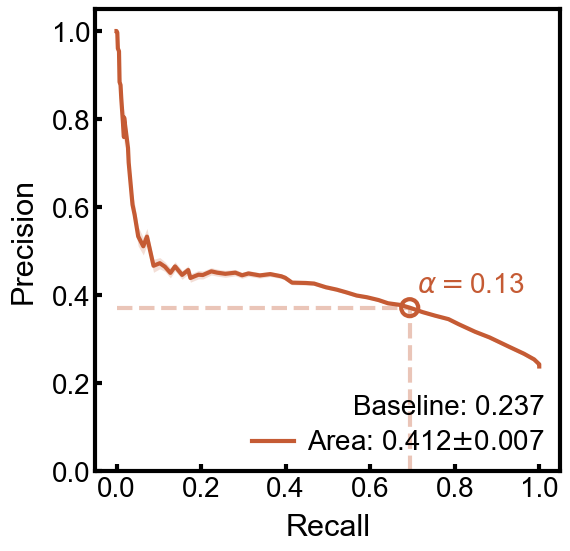

In [267]:
plot_prcurve(tpr, precision, baseline_accuracies=baseline_accuracies, x_adj=0.27, y_adj=0.08)

Area under the curve: 0.7166323128146985 $\plusminus$ 0.00663453555984328


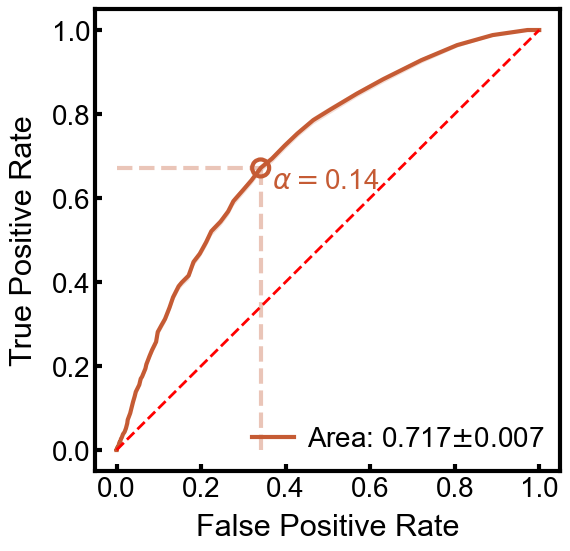

In [268]:
plot_roccurve(fpr, tpr, x_adj=0.28, y_adj=0.0)

## Explicit no-intention classification

In [3]:
exclude = [38, 88, 89, 92, 100, 104]
subjects = [n for n in np.arange(1, 110) if n not in exclude]
runs = [4, 6, 8, 10, 12, 14]
data_path = '/Users/seonghyunyoon/Developer/cp-eeg/Data/physionet_edf/'

x_all = []
y_all = []
for sub in subjects:
    x, y = Utils.epoch(
        Utils.eeg_settings(Utils.del_annotations(Utils.concatenate_runs(
        Utils.load_data(subjects=[sub], runs=runs, data_path=data_path)))),
        exclude_base=False)
    x_all.append(x)
    y_all.append(y)

X = np.vstack(x_all)
y = np.hstack(y_all)
X = np.expand_dims(X, axis=1)

from sklearn.utils import resample

baseline_target_num = 2300

rlf_idx = np.array([l == 'L' or l == 'R' or l == 'F' or l == 'LR' for l in y])
b_idx = np.array([l == 'B' for l in y])
X_baseline = X[b_idx]
baseline_num = np.sum(b_idx)

all_idx = np.arange(baseline_num)
baseline_idx = resample(all_idx, replace=False, n_samples=baseline_target_num, random_state=42)
baseline_idx_non = np.delete(all_idx, baseline_idx)
X_baseline_5class = X_baseline[baseline_idx]
X_baseline = X_baseline[baseline_idx_non]

y = np.hstack((y[rlf_idx], ['B'] * baseline_target_num))
X = np.vstack((X[rlf_idx], X_baseline_5class))

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=.9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=.5, random_state=42)

for j in range(64):
    scaler = StandardScaler()
    scaler.fit(X_train[:,0,j,:])
    X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
    X_val[:,0,j,:] = scaler.transform(X_val[:,0,j,:])
    X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])
    
# one-hot-encode the labels 
labels = ['B', 'L', 'R', 'F', 'LR']
y_train = to_categorical(np.asarray([labels.index(label) for label in y_train]))
y_val = to_categorical(np.asarray([labels.index(label) for label in y_val]))
y_test = to_categorical(np.asarray([labels.index(label) for label in y_test]))

Extracting EDF parameters from /Users/seonghyunyoon/Developer/cp-eeg/Data/physionet_edf/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
1
Extracting EDF parameters from /Users/seonghyunyoon/Developer/cp-eeg/Data/physionet_edf/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
1
Extracting EDF parameters from /Users/seonghyunyoon/Developer/cp-eeg/Data/physionet_edf/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
1
Extracting EDF parameters from /Users/seonghyunyoon/Developer/cp-eeg/Data/physionet_edf/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
1
Extr

In [4]:
X.shape

(11541, 1, 64, 641)

In [274]:
model = EEGTCNet(nb_classes=5, Chans=64, Samples=641, layers=L, kernel_s=KT,filt=FT, dropout=pt, activation='elu', F1=F1, D=2, kernLength=KE, dropout_eeg=pe)
model.load_weights(f'{model_path}/model_physionet.h5')

In [276]:
from keras.models import Model
from sklearn.manifold import TSNE

# Get embeddings
embedding_model = Model(inputs=model.input, outputs=model.get_layer('lambda_101').output)
embeddings = embedding_model.predict(np.vstack((X_val, X_test)))

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=20)
X_tsne = tsne.fit_transform(embeddings)
y_tsne = np.vstack((y_val, y_test)).argmax(1)

37/37 [==============================] - 1s 25ms/step


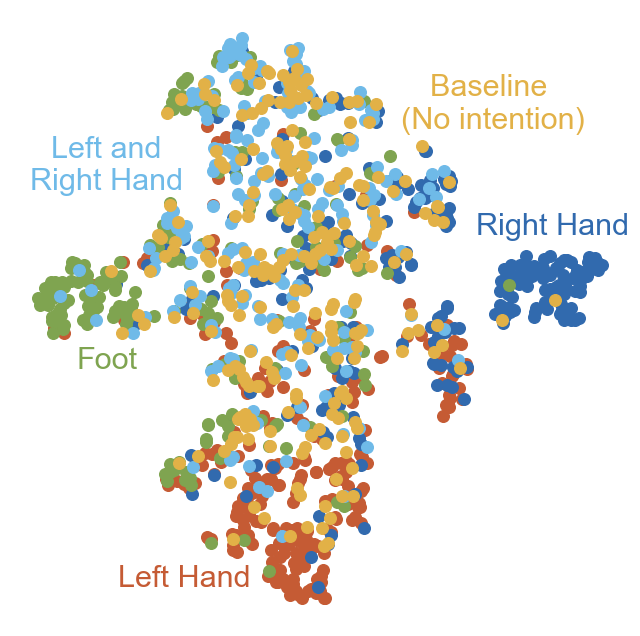

In [277]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
plot_labels = ['L', 'R', 'F', 'LR', 'B']
real_labels = ['Left Hand', 'Right Hand', 'Foot', 'Left and\nRight Hand', 'Baseline \n(No intention)']
label_locs = [(-25, -50), (55, 13), (-42, -11), (-42, 24), (42, 35)]

plt.figure(figsize=(8, 8))
for i in range(5):  # Assuming 5 classes
    indices = y_tsne == i
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'{plot_labels[i]}', marker='o', s=70, color=color_scheme[i])
    plt.text(label_locs[i][0], label_locs[i][1], real_labels[i], fontsize=22, ha='center', va='center', color=color_scheme[i])
plt.xticks([])
plt.yticks([])
# Removing the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Optionally, if you also want to remove the bottom and left spines:
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


plt.show()

In [278]:
# Index 0 is no-intention
from sklearn.model_selection import KFold

n_splits = 10
all_alphas = list(np.arange(0.01, 1.00, 0.01))
kf = KFold(n_splits=n_splits)
n_iters = 1000

prediction_rates = np.zeros((n_splits, len(all_alphas), n_iters))
true_positives = np.zeros((n_splits, len(all_alphas), n_iters)); true_negatives = np.zeros((n_splits, len(all_alphas), n_iters))
false_positives = np.zeros((n_splits, len(all_alphas), n_iters)); false_negatives = np.zeros((n_splits, len(all_alphas), n_iters))

for fold_idx, (train_index, test_index) in tqdm(enumerate(kf.split(X_test)), total=n_splits): 
    X_fold, y_fold = X_test[test_index], y_test[test_index]
    val_smx = model.predict(X_val, verbose=False)
    test_smx = model.predict(X_fold, verbose=False)
    true_abstain = np.logical_or(y_fold.argmax(1) == 0, test_smx.argmax(1) != y_fold.argmax(1))  # Either no intention or wrong prediction
    true_noabstain = ~true_abstain
    for i_alpha, alpha in enumerate(all_alphas): 
        for j in range(n_iters): 
            ps, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=1-alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True, verbose=False)
            pred_abstain = np.logical_or(np.sum(ps, axis=1) > 1, test_smx.argmax(1) == 0)  # Either abstains or predicts no intention
            pred_noabstain = ~pred_abstain
            tp = np.sum(np.logical_and(pred_abstain, true_abstain)); fp = np.sum(np.logical_and(pred_abstain, true_noabstain))
            fn = np.sum(np.logical_and(pred_noabstain, true_abstain)); tn = np.sum(np.logical_and(pred_noabstain, true_noabstain))
            assert tp + fp + fn + tn == X_fold.shape[0]
            true_positives[fold_idx, i_alpha, j] = tp; true_negatives[fold_idx, i_alpha, j] = tn
            false_positives[fold_idx, i_alpha, j] = fp; false_negatives[fold_idx, i_alpha, j] = fn
            prediction_rates[fold_idx, i_alpha, j] = np.mean(np.sum(ps, axis=1) == 1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [279]:
np.save(f'{save_path}true_positives_physionet.npy', true_positives)
np.save(f'{save_path}true_negatives_physionet.npy', true_negatives)
np.save(f'{save_path}false_positives_physionet.npy', false_positives)
np.save(f'{save_path}false_negatives_physionet.npy', false_negatives)

In [221]:
prediction_rates_flattened = np.zeros((9 * n_iters, len(all_alphas)))

for subject_num in range(9):
    for i in range(n_iters): 
        save_idx = n_iters*subject_num+i
        prediction_rates_flattened[save_idx,:] = prediction_rates[subject_num,:,i]

In [222]:
tpr, fpr, precision = compute_matrix_quantities(true_positives, true_negatives, false_positives, false_negatives)

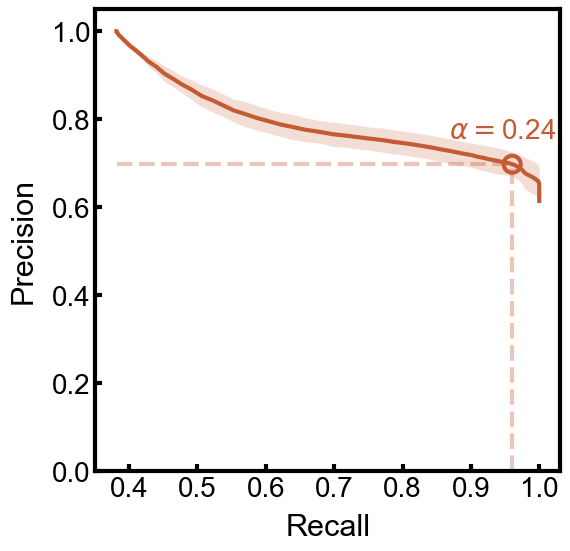

In [223]:
plot_prcurve(tpr, precision, print_area=False, x_adj=0.065, y_adj=0.105)

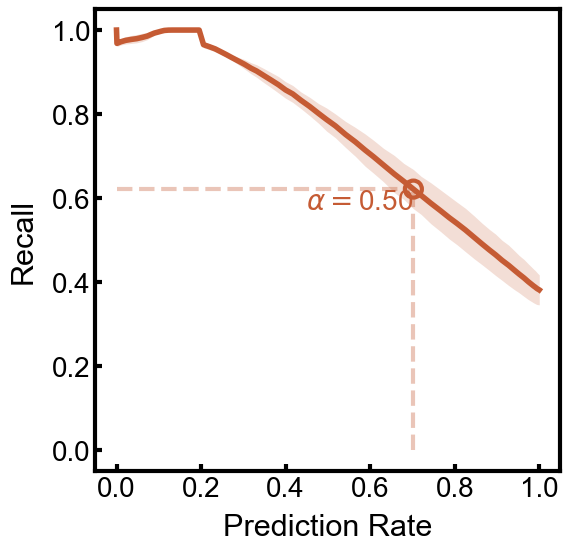

In [224]:
plot_prr_curve(np.flip(np.mean(prediction_rates_flattened, axis=0)), tpr)

Area under the curve: 0.7964441911585709 $\plusminus$ 0.022670202344381885


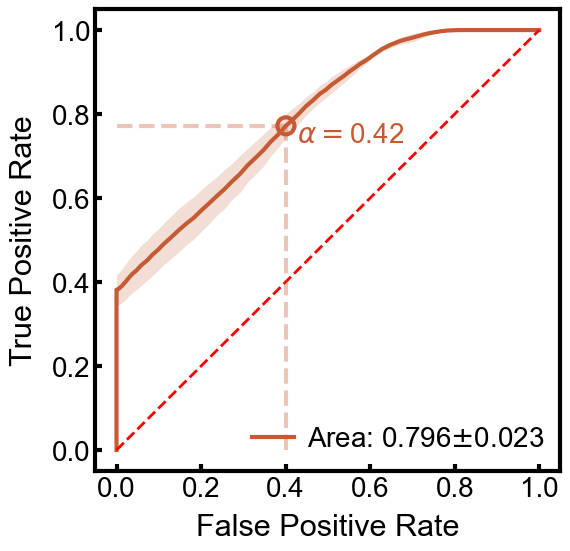

In [225]:
plot_roccurve(fpr, tpr, x_adj=0.28, y_adj=0.01)